In [1]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras import Input
from keras.layers import Dense,LSTM
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
LENGTH_INPUT = 500

In [3]:
def define_discriminator(n_inputs=LENGTH_INPUT):
    model = Sequential()
    model.add(Dense(LENGTH_INPUT, activation='relu', input_dim=n_inputs))  # Can change 'relu'
    model.add(Dense(250, activation='leaky_relu'))  # Example: Leaky ReLU
    model.add(Dense(100, activation='tanh'))  # Example: tanh
    model.add(Dense(1, activation='sigmoid'))  # Change for multi-class or regression
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['mean_squared_error'])
    return model

In [4]:
def define_generator(latent_dim, n_outputs=LENGTH_INPUT):
    model = Sequential()
    model.add(Input(shape=(latent_dim, 1)))
    model.add(LSTM(150))
    model.add(Dense(LENGTH_INPUT, activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='sgd', metrics=['mean_absolute_error'])

    return model

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    return model


In [6]:
# generate n real samples with class labels
def generate_real_samples(n):
    amps = np.arange(0.1,10,0.1)
    bias = np.arange(0.1,10,0.1)
    freqs = np.linspace(1,2,500)
    X2 = np.linspace(-5,5,LENGTH_INPUT)
    X1 = []
    for x in range(n):
        noise = np.random.normal(size=len(X2))
        X1.append(np.random.choice(amps)*np.sin(X2*np.random.choice(freqs))+np.random.choice(bias)+0.3*noise)
    X1 = np.array(X1).reshape(n, LENGTH_INPUT)
    # generate class labels
    y = ones((n, 1))
    return X1, y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input, verbose=0)
    # create class labels
    y = zeros((n, 1))
    #print(x_input)
    return X, y


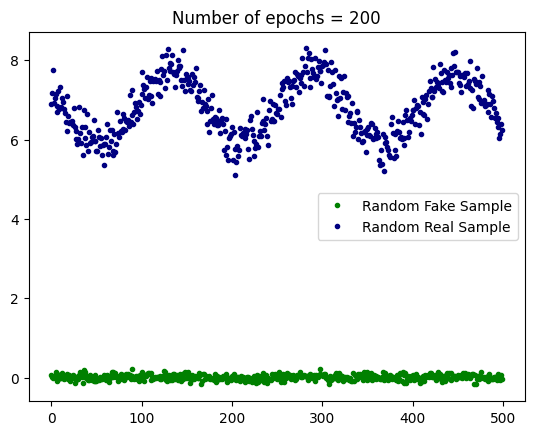

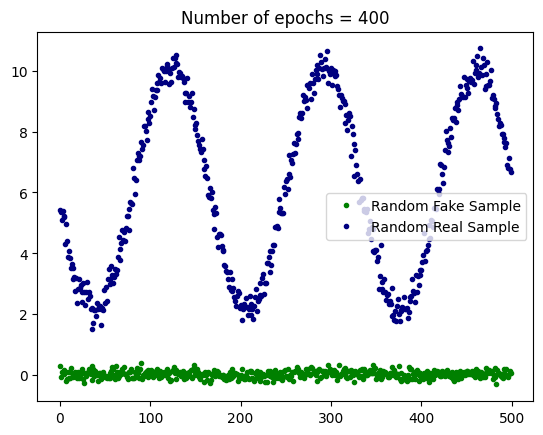

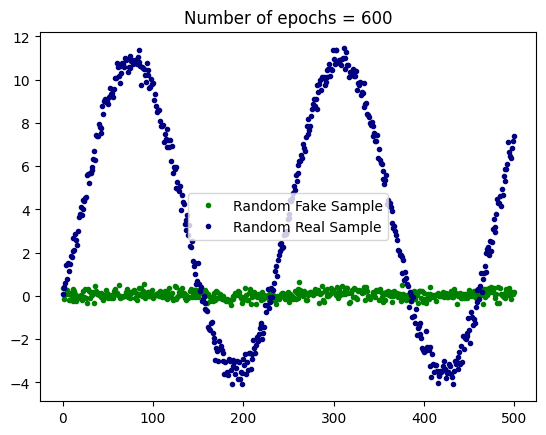

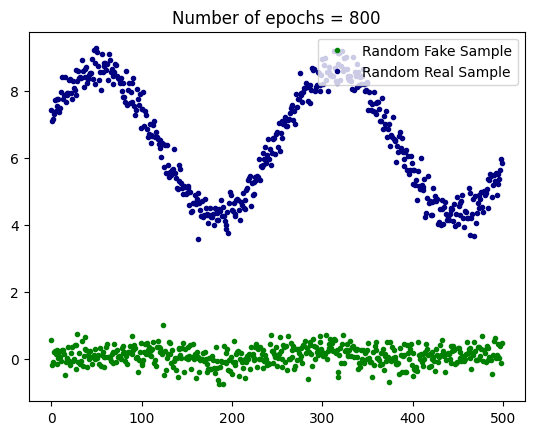

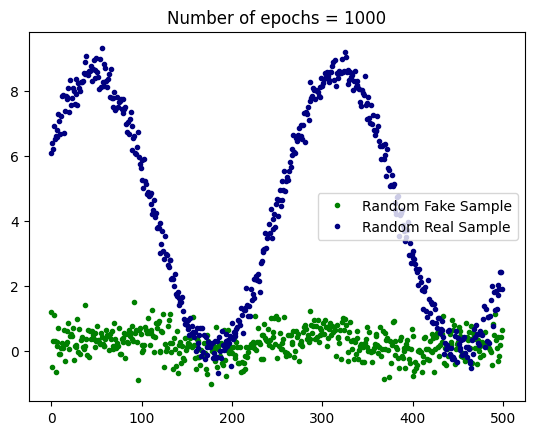

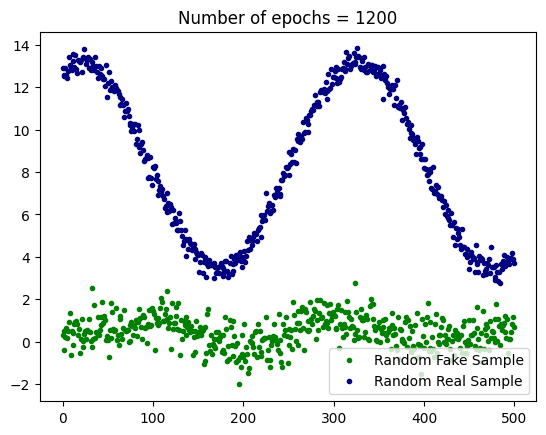

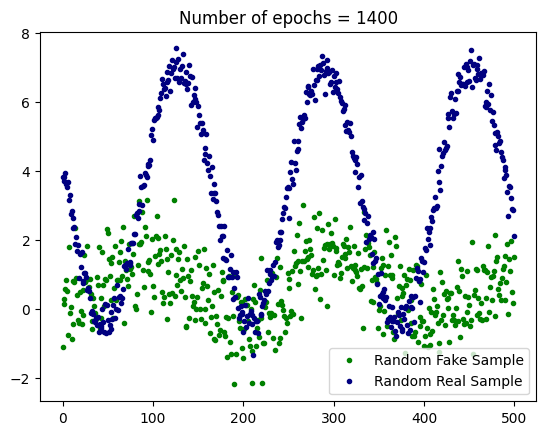

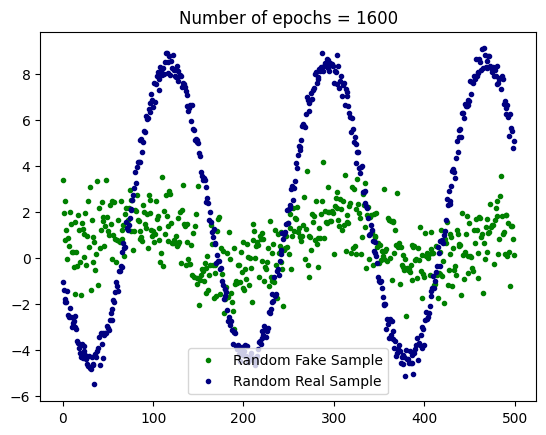

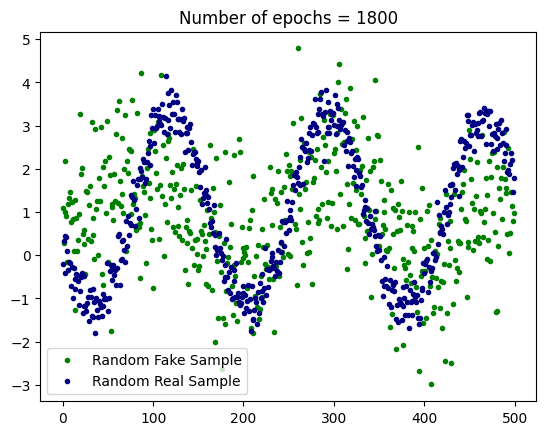

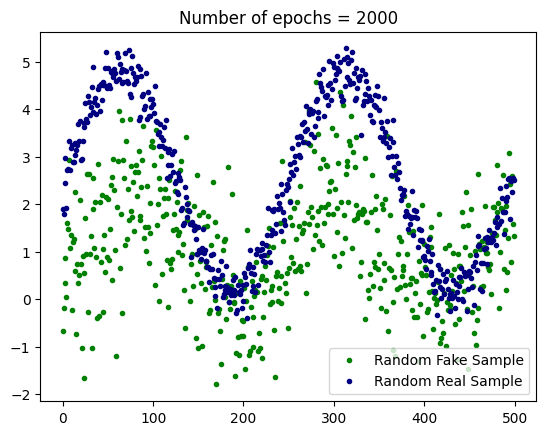

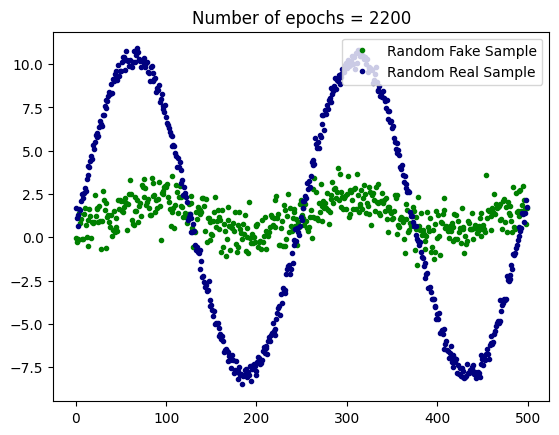

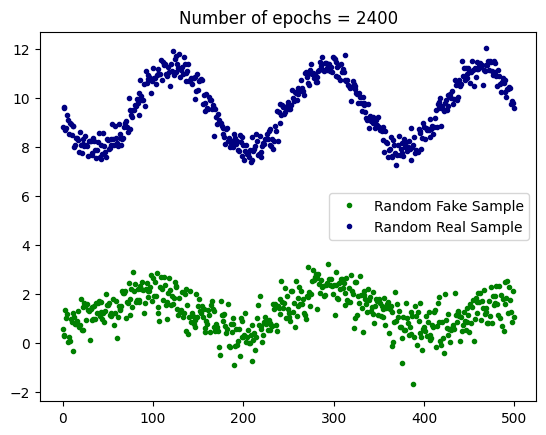

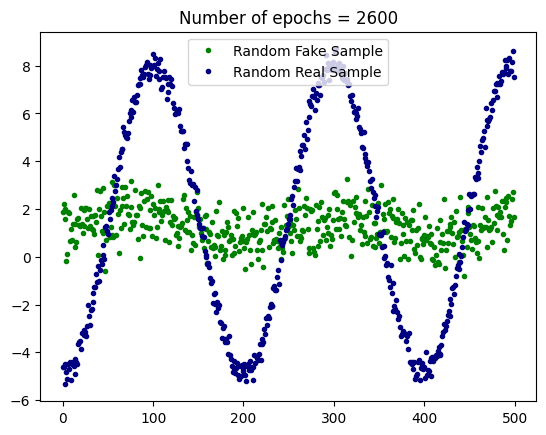

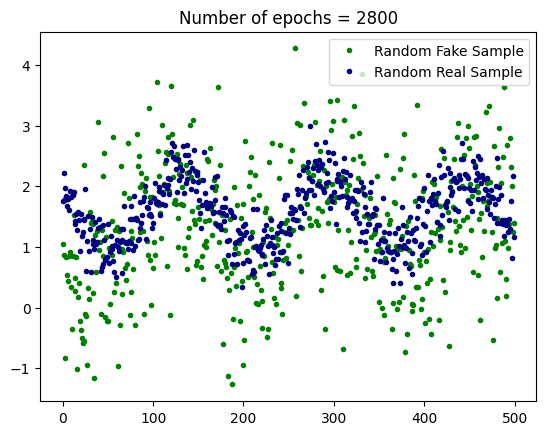

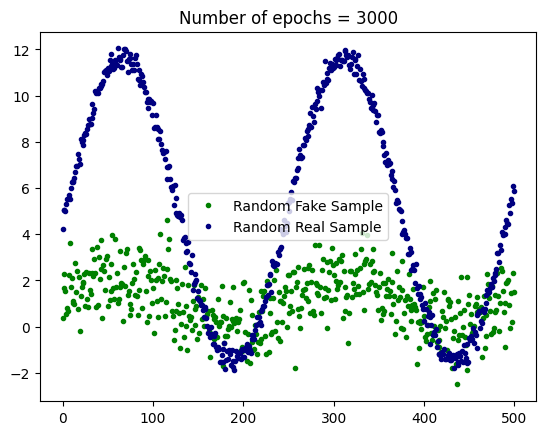

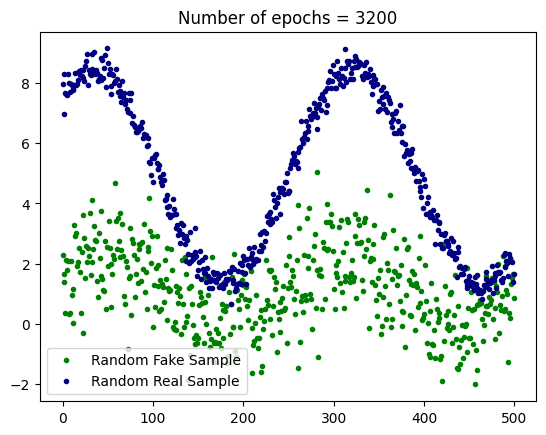

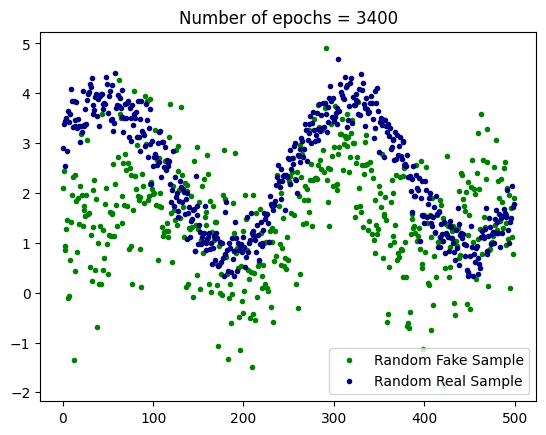

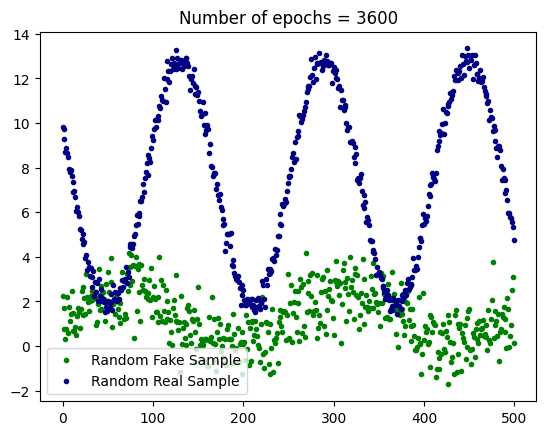

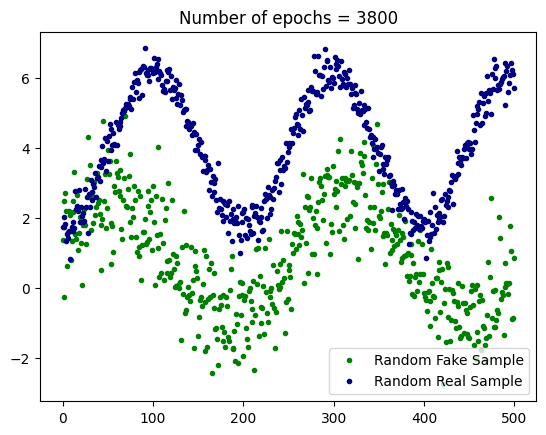

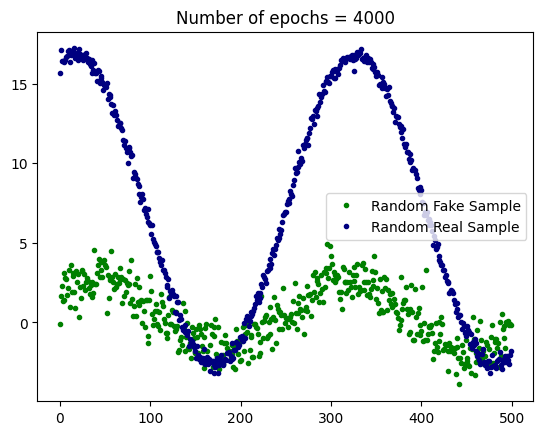

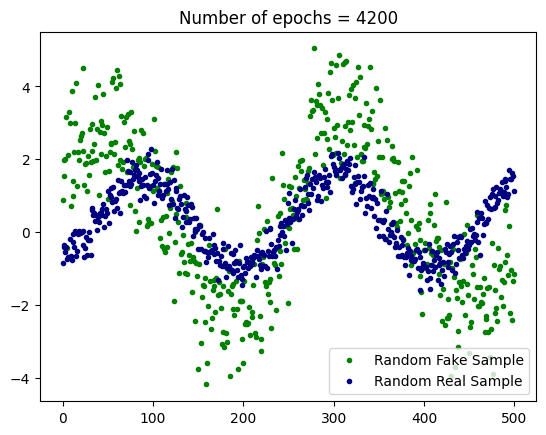

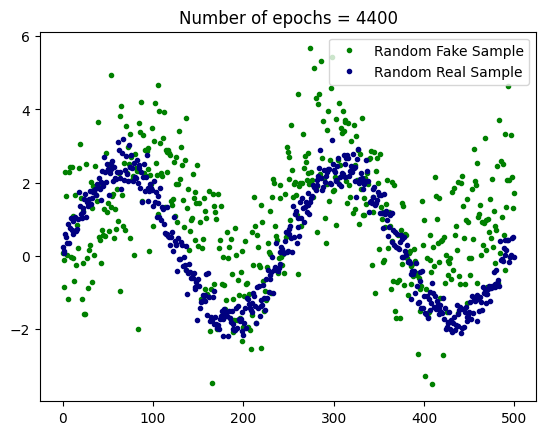

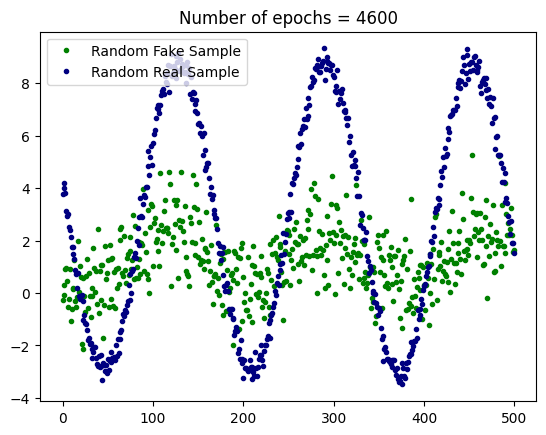

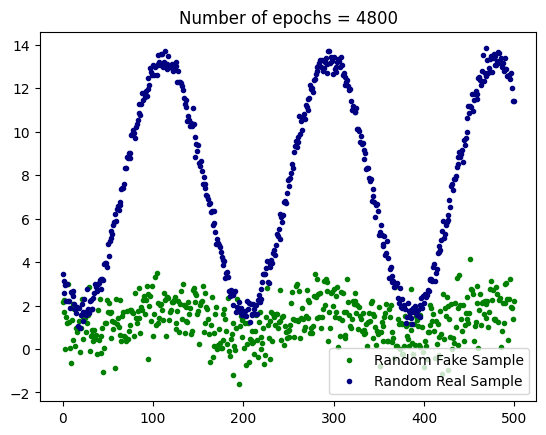

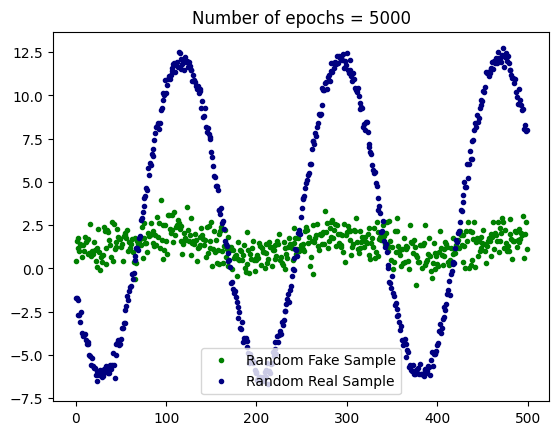

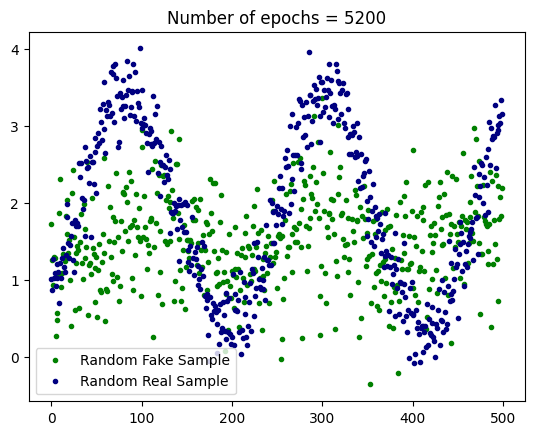

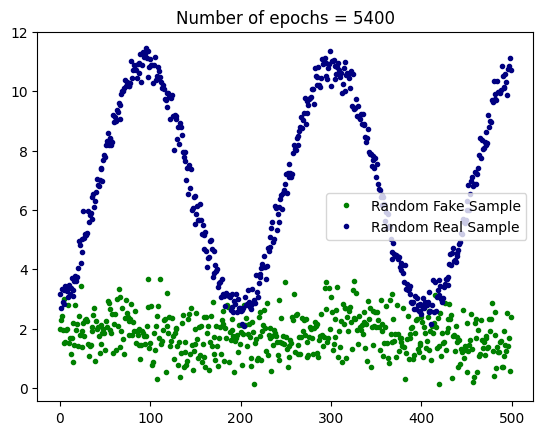

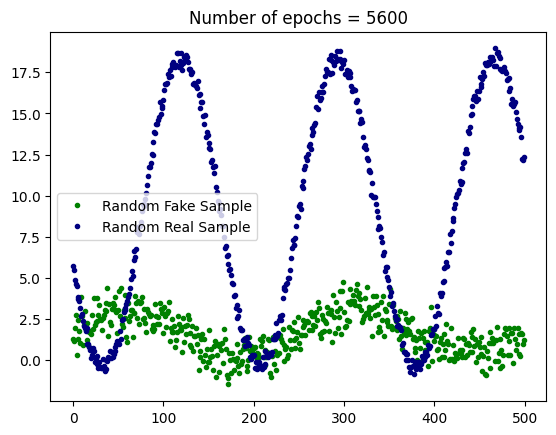

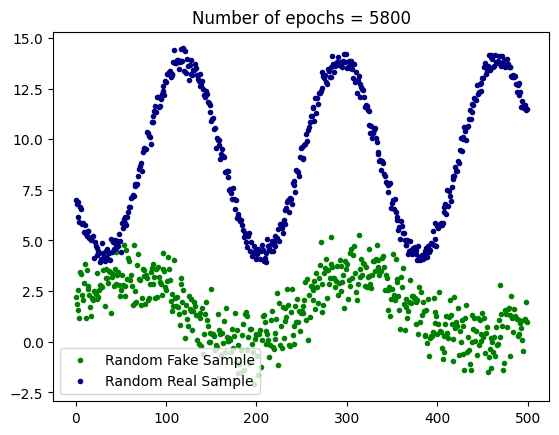

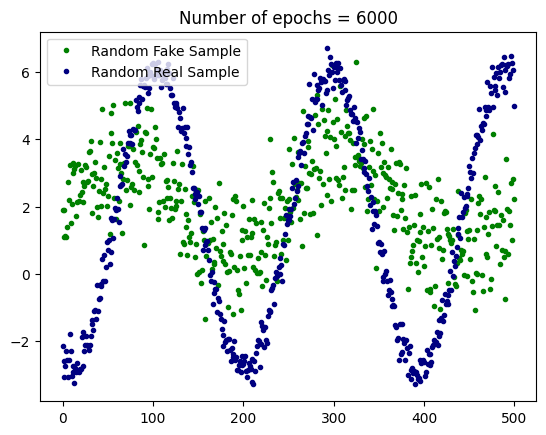

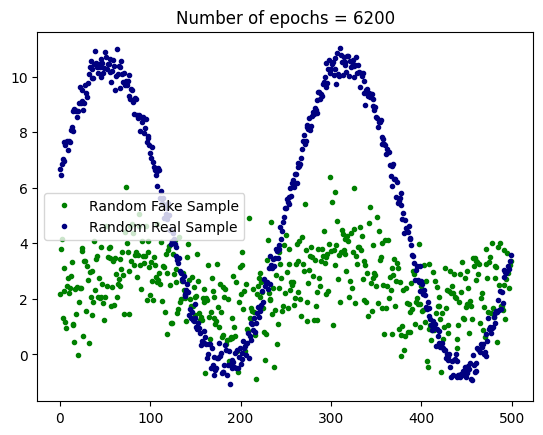

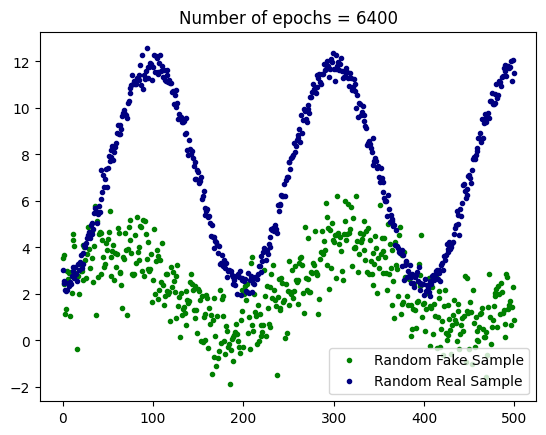

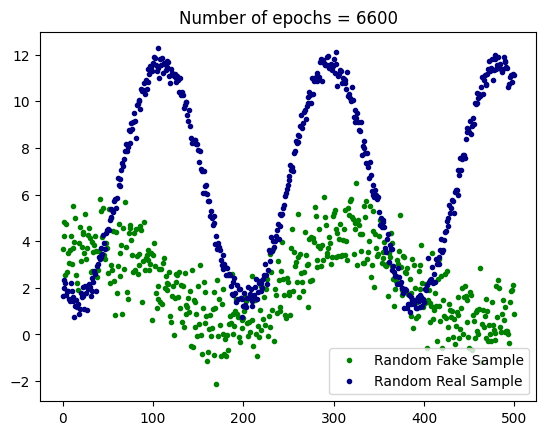

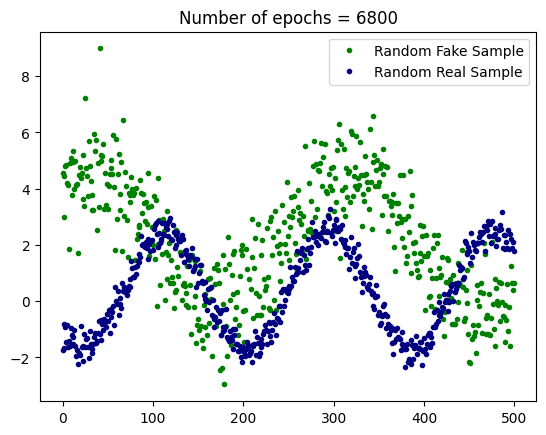

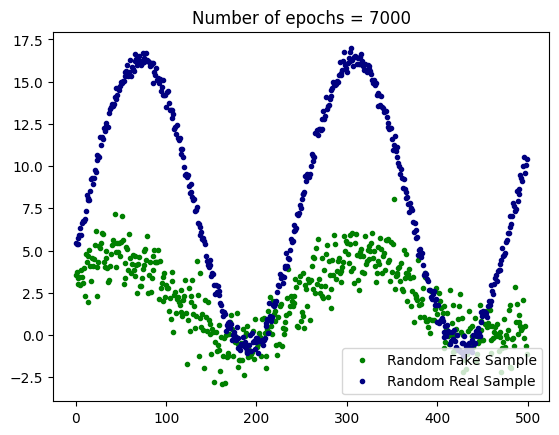

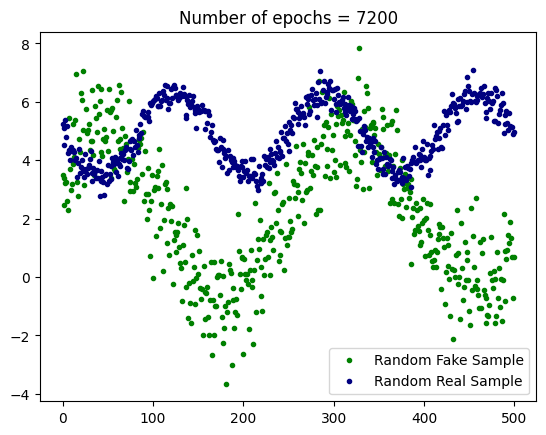

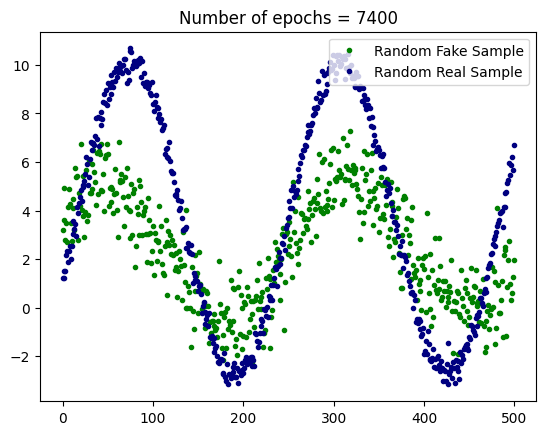

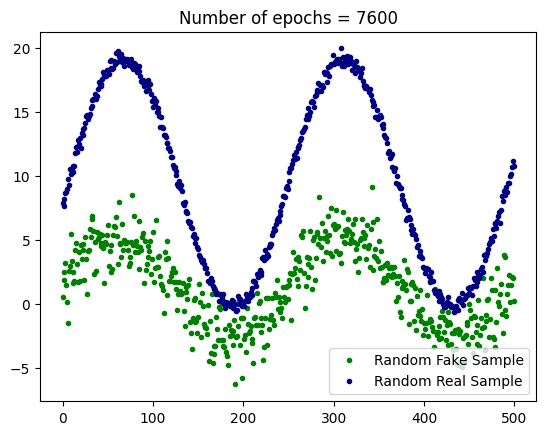

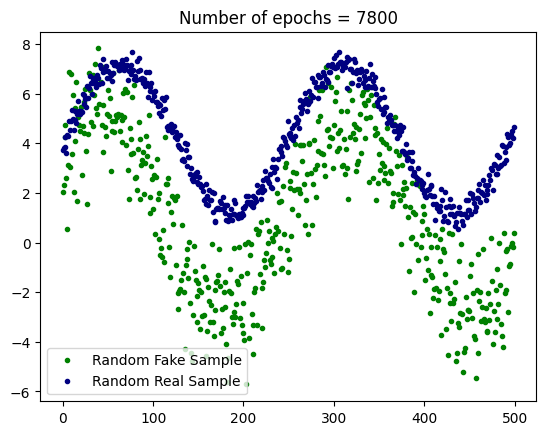

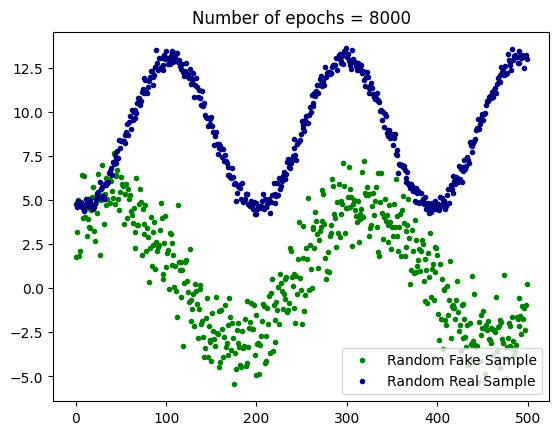

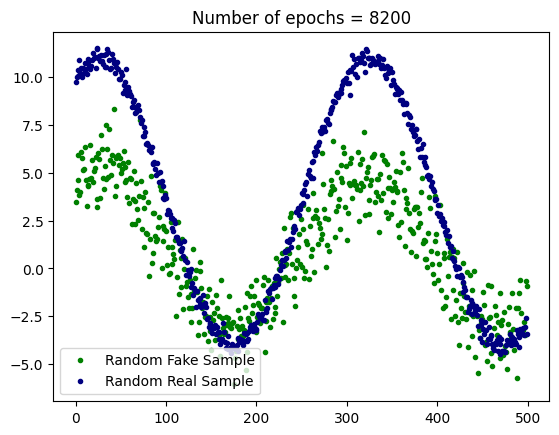

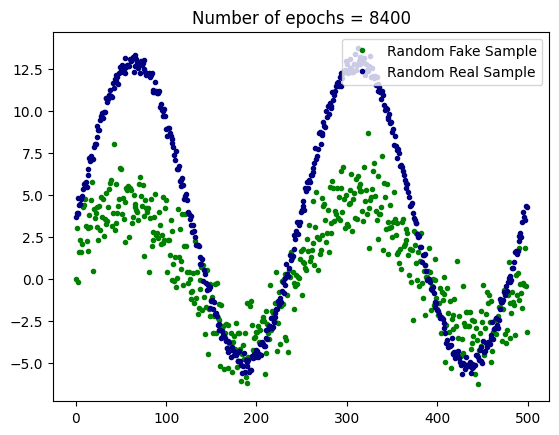

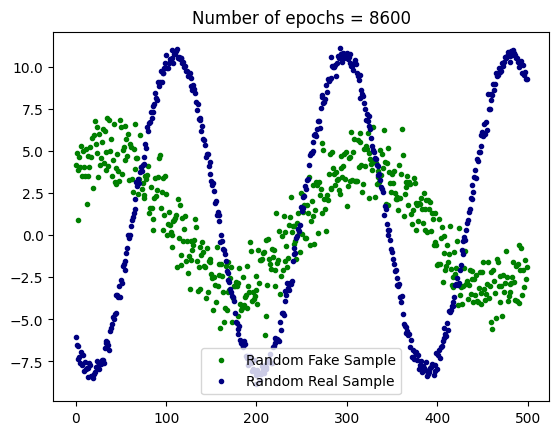

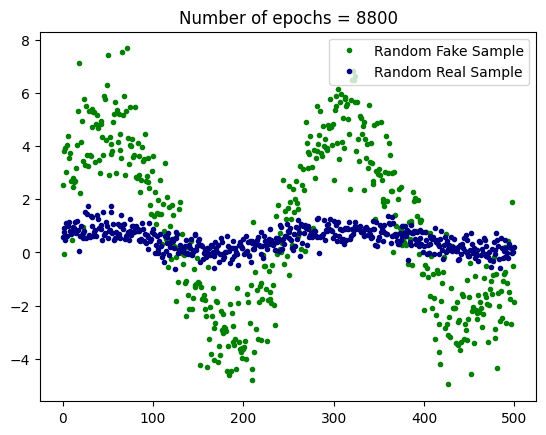

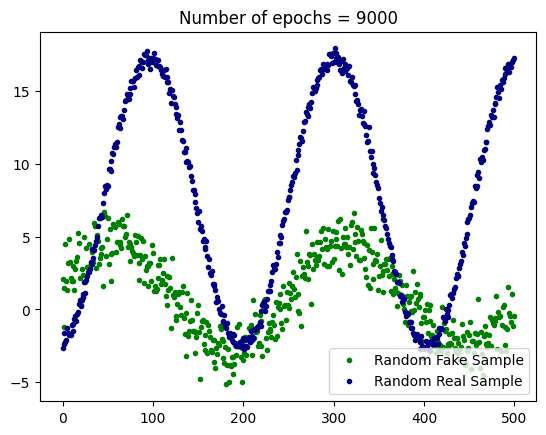

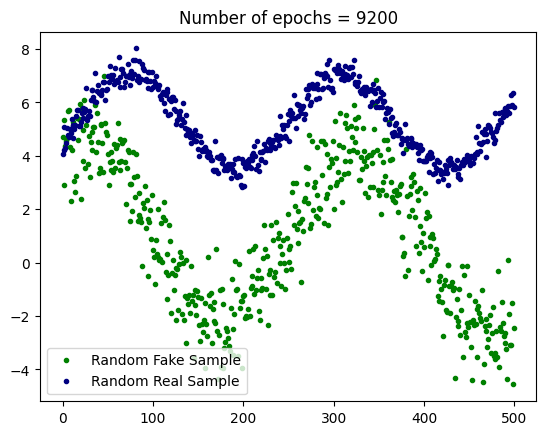

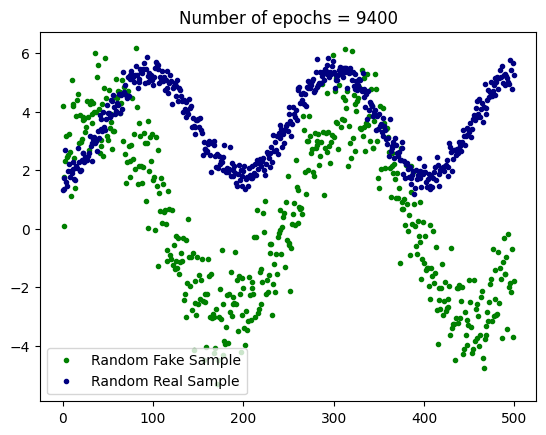

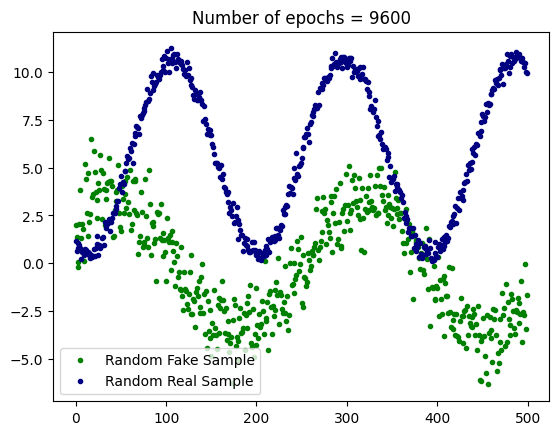

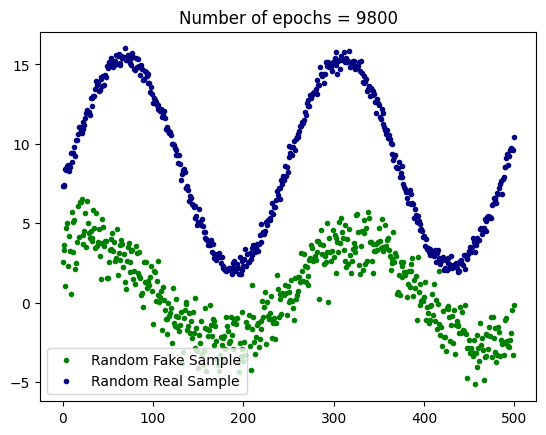

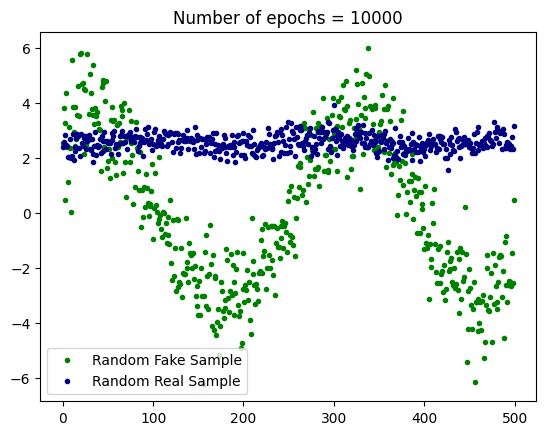

In [8]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            plt.title('Number of epochs = %i'%(i+1))
            pred_data = generate_fake_samples(generator,latent_dim,latent_dim)[0]
            real_data  = generate_real_samples(latent_dim)[0]
            plt.plot(pred_data[0],'.',label='Random Fake Sample',color='green')
            plt.plot(real_data[0],'.',label = 'Random Real Sample',color='navy')
            plt.legend(fontsize=10)
            plt.show()
# size of the latent space
latent_dim = 3
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [9]:
pred_data = generate_fake_samples(generator,5,100000)[0]

In [10]:
real_data  = generate_real_samples(100000)[0]

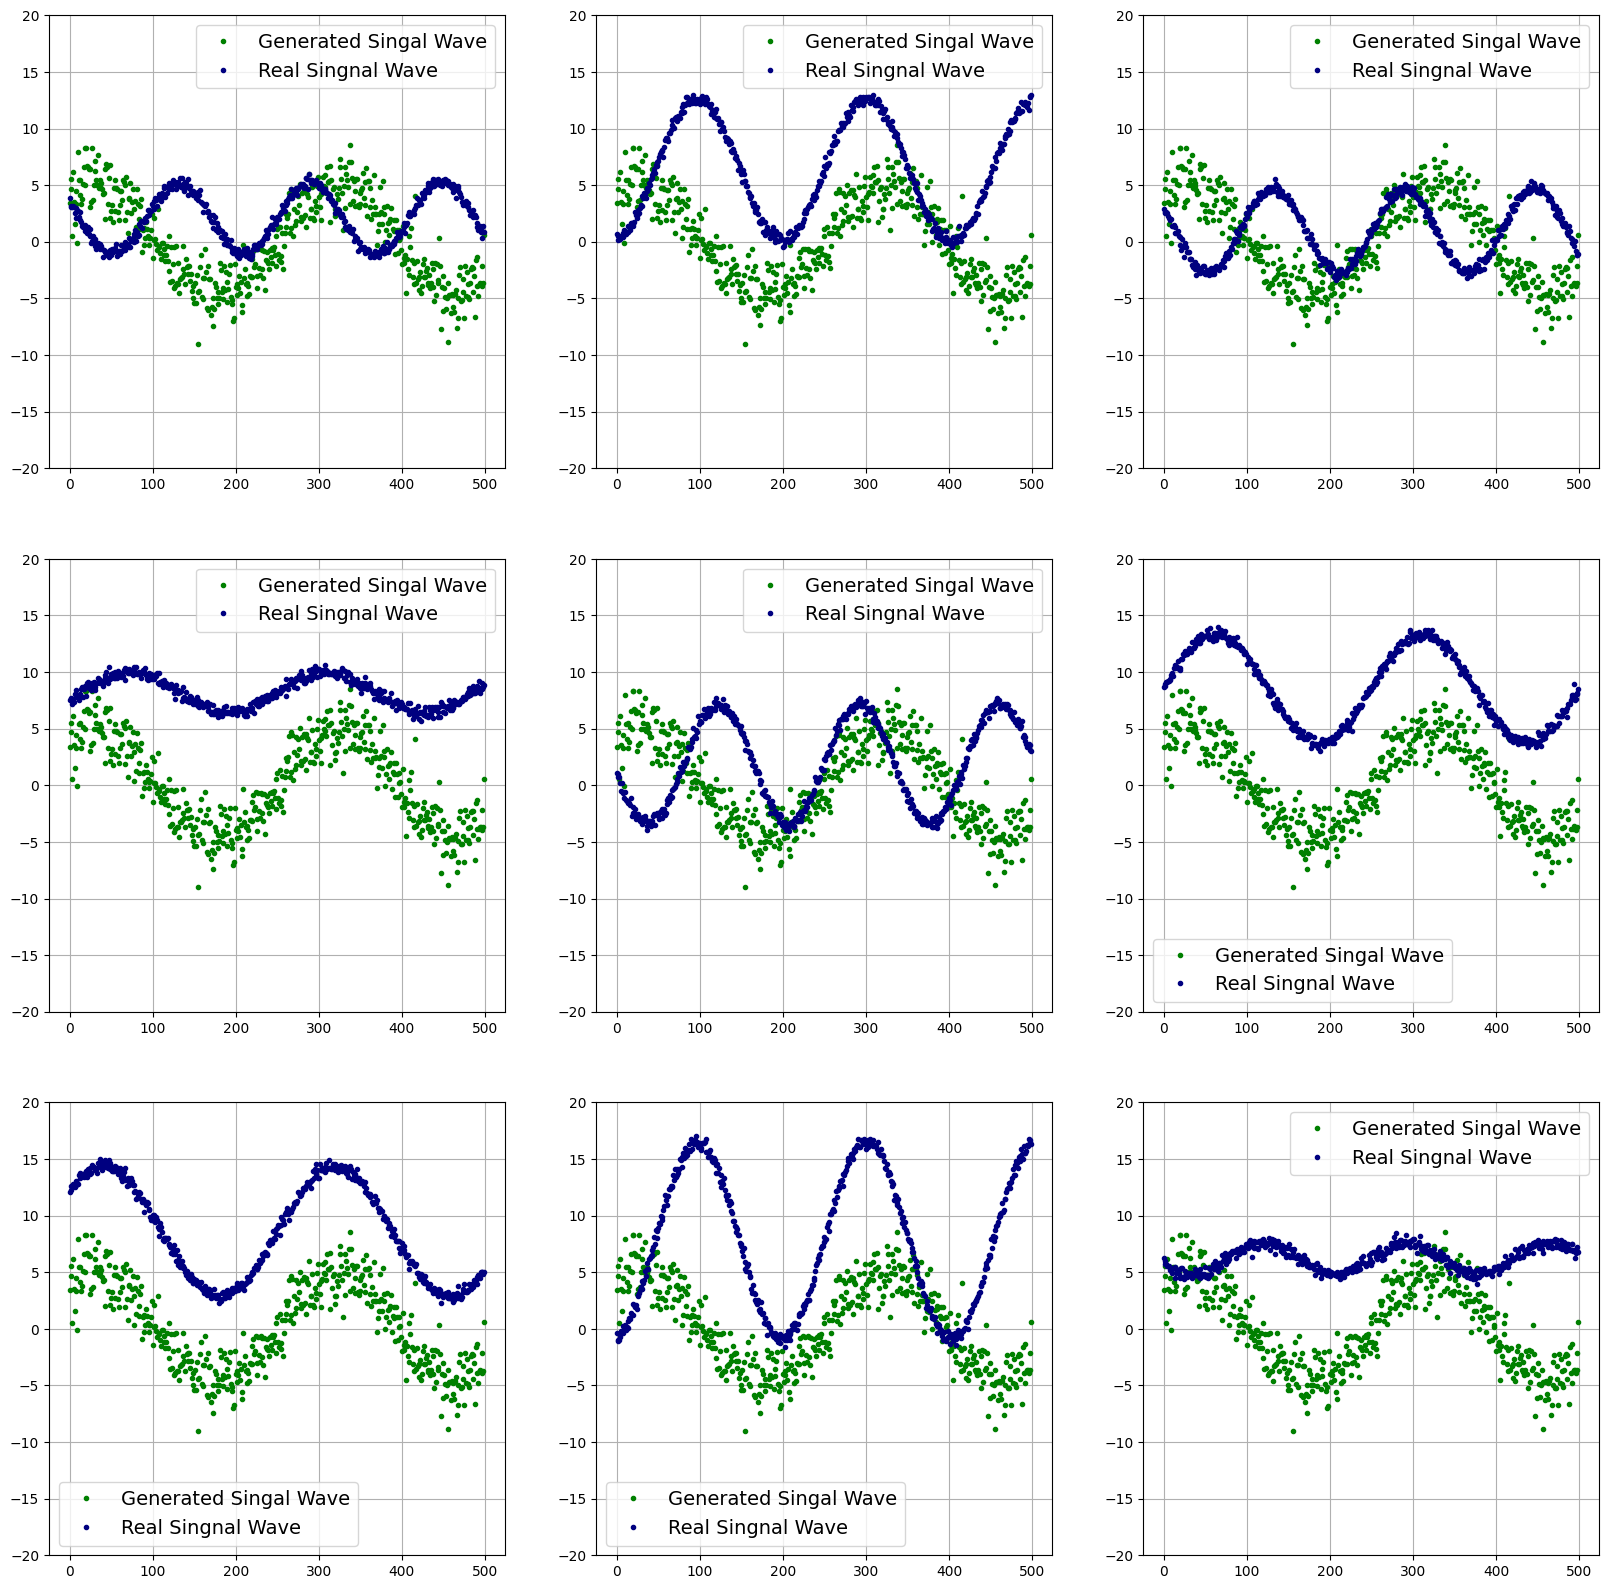

In [12]:
k=1
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,k)
    J = np.random.choice(np.random.choice(range(0,len(pred_data))))
    plt.plot(pred_data[J],'.',color='green',label='Generated Singal Wave')
    plt.plot(real_data[J],'.',color='navy',label='Real Singnal Wave')
    plt.legend(fontsize=14)
    plt.ylim(-20,20)
    plt.grid(True)
    k=k+1